In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000259F182E6F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000259F182F770>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [4]:
def generate_subtopics(state: MessagesState) -> MessagesState:
    topic = state["messages"][-1].content  # Get topic from last message

    # Prompt the LLM to generate multiple subtopics
    response = llm.invoke(f"Generate as many detailed subtopics as possible on: {topic}")
    subtopics = [sub.strip() for sub in response.content.split("\n") if sub.strip()]

    # Store subtopics as AI messages
    subtopic_messages = [AIMessage(content=subtopic) for subtopic in subtopics]

    return {"messages": subtopic_messages}

import concurrent.futures

# Function to generate content for all subtopics in parallel
def generate_content(state: MessagesState) -> MessagesState:
    subtopics = [msg.content for msg in state["messages"]]

    generated_messages = []

    def generate_for_subtopic(subtopic):
        try:
            response = llm.invoke(f"Write a detailed, well-structured explanation on: {subtopic}")
            content = response.content.strip() if response else "Content generation failed."
        except Exception as e:
            content = f"Error generating content: {str(e)}"
        
        return AIMessage(content=f"### {subtopic}\n\n{content}")

    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(generate_for_subtopic, subtopics))

    return {"messages": results}


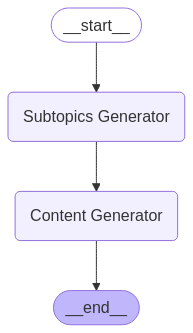

In [5]:
from langgraph.graph import START, StateGraph, END

builder=StateGraph(MessagesState)

builder.add_node("Subtopics Generator",generate_subtopics)
builder.add_node("Content Generator",generate_content)

builder.add_edge(START,"Subtopics Generator")
builder.add_edge("Subtopics Generator","Content Generator")
builder.add_edge("Content Generator",END)

graph=builder.compile()
graph

In [6]:
messages = [HumanMessage(content="Python")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Python
================================== Ai Message ==================================

Here are some detailed subtopics on Python:
================================== Ai Message ==================================

**Basics**
================================== Ai Message ==================================

1. **Variables and Data Types**:
================================== Ai Message ==================================

* Integers, Floats, Strings, Booleans, Lists, Tuples, Dictionaries
================================== Ai Message ==================================

* Type casting, type conversion, and implicit type conversion
================================== Ai Message ==================================

* Variable naming conventions and best practices
================================== Ai Message ==================================

2. **Operators and Control Structures**:
==============================